# Imports

In [25]:
import itertools
import copy
from collections import namedtuple
from enum import Enum
import math
from functools import reduce
from operator import mul

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset

# Bulk data concatenation

In [8]:
data_path = "../training_data/"
data_levelsets = ["train1", "train2", "train3", "train4"]
data_levels = range(1, 990+1)
observation_ext = "observation.zip"
feature_ext = "feature.zip"

def _addRowAndCol(feature_tensor):
    # 3xnxn -> 3x(n+1)x(n+1)
    n = feature_tensor.size()[1]
    channels = []
    new_col = torch.zeros(n, 1)
    new_row = torch.zeros(1, n+1)
    for channel in feature_tensor:
        output_tensor = torch.cat((channel, new_col), dim=1)
        output_tensor = torch.cat((output_tensor, new_row), dim=0)
        channels.append(output_tensor)
    return torch.stack(channels)
    

def dataGatherOnlyObservedSolutions():
    features = []
    observations = []
    for levelset, levelnum in itertools.product(*[data_levelsets, data_levels]):
        level_feature_path = '{}{}_{}_{}'.format(data_path, levelset, levelnum, feature_ext)
        level_observation_path = '{}{}_{}_{}'.format(data_path, levelset, levelnum, observation_ext)
        
        level_features = torch.load(level_feature_path)
        level_observations = torch.load(level_observation_path)
        
        for feat, obs in zip(level_features, level_observations):
            if obs[1] == 1:
#                 features.append(feat.clone())
                features.append(_addRowAndCol(feat.clone()))
                observations.append(torch.tensor([obs[0].clone()], dtype=torch.float32))
        del level_features
        del level_observations
                
    return torch.stack(features), torch.stack(observations)

# Data Preprocessing and Standardizing
- Features are standardized to mean 0 and std 1
- Observations are normalzed to range [0,1]

In [33]:
def preprocessFeatures(features):
    # features is shape [N, 2, 39, 39]
    # permute to channel is top most axis
    temp_feats = features.clone().permute(*[i for i in range(1, len(features.shape))], 0).contiguous()
    # Calculate mean/std for standardization
    mean = temp_feats.view(2, -1).mean(dim=1)
    std = temp_feats.view(2, -1).std(dim=1)
    # Normalize original features
    for f in features:
        for i, (mu, sigma) in enumerate(zip(mean.tolist(), std.tolist())):
            f[i].sub_(mu)
            f[i].div_(sigma)
    
    return features

def preprocessObservations(observations):
    return torch.log(observations)
#     return observations / max(observations)
#     return torch.log(observations) / max(torch.log(observations))

def getDataLoader(features, observations, batch_size=64):
    data = [(feat, obs) for feat, obs in zip(features, observations)]
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        

# Model

In [121]:
class DisNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        ks1 = 3
        ks2 = 3
        ks3 = 1
        
        conv1_depth = 16
        conv2_depth = 32
        
        # convolution layers
        self.conv1 = nn.Conv2d(2, conv1_depth, kernel_size=ks1, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(conv1_depth, conv2_depth, kernel_size=ks2, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(conv2_depth, 1, kernel_size=ks3, stride=1, padding=0)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        
        # pooling
        self.maxPool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.3)
#         self.avgPool = nn.AveragePool2d(2, 2)
        # subsampling
        
        # FC
        self.fc1 = nn.Linear(40*40, 64)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(64, 32)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(32, 1)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout1(F.relu(self.fc2(x)))
        x = self.dropout2(F.relu(self.fc3(x)))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    


In [90]:
class FCN(nn.Module):
    def __init__(self, fc1_size=64, fc2_size=32):
        super().__init__()
        self.dropout = nn.Dropout2d(0.0)
        
        self.fc1 = nn.Linear(40*40*2, fc1_size)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(fc2_size, 1)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
    
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Training loop

In [96]:
# Options = namedtuple('Options', ['n_epochs', 'batch_size', 'start_rate', 'end_rate', 'clip_gradient_norm', 
#                                  'loss_fn', 'verbose']
#                     )
# default_options = Options(n_epochs=100, batch_size=64, start_rate=1e-3, end_rate=1e-5, 
#                           clip_gradient_norm=1e-2, loss_fn=nn.MSELoss(), verbose=False
#                          )
default_options = {'n_epochs' : 100, 'batch_size' : 64, 'start_rate' : 1e-3, 'end_rate' : 1e-5, 
                          'clip_gradient_norm' : 1e-2, 'loss_fn' : nn.MSELoss(), 'verbose' : False
                  }

In [104]:
# def train(features, observations, options=default_options):
def train(model, device, train_loader, validation_loader, options=default_options):
    
    # Set device
    model.to(device)
    
    # Get training attributes from options
    loss_fn = options['loss_fn']
    start_rate = options['start_rate']
    end_rate = options['end_rate']
    n_epochs = options['n_epochs']
    clip_gradient_norm = options['clip_gradient_norm']
#     loss_fn = nn.NLLLoss()
    
    # Optimizers
    # - learning rate start 1e-3 to end 1e-5 [done]
    # - gradient clipping [done]
    # - tanh activation function
    # - SGD [done]
    # - batch normalization (as a layer)
    # - L2 regularization of 1e-4
    decay_rate = np.exp(np.log(end_rate / start_rate) / n_epochs)
    
    optimizer = optim.SGD(model.parameters(), lr=start_rate)
#     optimizer = optim.SGD(model.parameters(), lr=start_rate, weight_decay=0.01)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
    
    loss_values = []
    for epoch in range(n_epochs):
        training_loss = 0.0
        for i, data in enumerate(train_loader):
            # get the inputs; data is a list of [features, runtime]
            inputs, rts = data
            inputs, rts = inputs.to(device), rts.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Propogate input to model and calculate loss
            batch_size = inputs.shape[0]
            outputs = model(inputs)
            loss = loss_fn(outputs, rts)
            
            # Add l2 loss
            
            # Clip the gradients
            if clip_gradient_norm != None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_gradient_norm)
            
            # Propogate loss backwards and step optimizer
            loss.backward()
            optimizer.step()
            
#             running_loss =+ loss.item() * inputs.size(0)
            training_loss += loss.item()
            
        # Get validation loss
        validation_loss = 0.0
        for i, data in enumerate(validation_loader):
            inputs, rts = data
            inputs, rts = inputs.to(device), rts.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, rts)
            validation_loss += loss.item()
            
        # Store training and validation loss
        loss_values.append((training_loss / len(train_loader), validation_loss / len(validation_loader)))
        if options['verbose'] and epoch % 10 == 9: print("Epoch: %d, Loss: %f" % (epoch, float(loss_values[-1][0])))
        
        # Update learning rate
        lr_scheduler.step()
    return loss_values, model

# Testing

### Single set validation

In [20]:
def validate(features, observations, model, options=default_options):
    # Preprocess input
    features = preprocessFeatures(features)
    observations = preprocessObservations(observations)
    
    # Create dataloader
    test_loader = getDataLoader(features, observations, options.batch_size)
    
    # Don't need to backprop during testing
    with torch.no_grad():
        for i, data in enumerate(test_loader):
             # get the inputs; data is a list of [features, runtime]
            inputs, rts = data
            inputs, rts = inputs.to(device), rts.to(device)   

### K-Fold Validation

In [106]:
def kfoldValidation(features, observations, options, model):
    # Get training attributes from options
    batch_size = options['batch_size']
    loss_fn = options['loss_fn']
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    test_losses = []
    for training_idx, test_idx in kf.split(features):
        # Split data
        train_features, test_features = features[training_idx,:], features[test_idx,:]
        train_observations, test_observations = observations[training_idx,:], observations[test_idx,:]
        
        # Create dataloaders
        train_loader = getDataLoader(train_features, train_observations, batch_size)
        test_loader = getDataLoader(test_features, test_observations, batch_size)
        
        # Train model
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        loss_values, model = train(model, device, train_loader, test_loader, options)
        
        # Test 
        # Don't need to backprop during testing
        test_loss = 0.0
        with torch.no_grad():
            for data in test_loader:
                inputs, rts = data
                inputs, rts = inputs.to(device), rts.to(device)  
                outputs = model(inputs)
                loss = loss_fn(outputs, rts)
                test_loss += loss.item()
                
        # Save avg loss
        test_losses.append(test_loss / len(test_loader))
        
    # Average losses
    return np.mean(test_losses)
        

# Util and Graphing

In [21]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Main Scripts

### FNN Model Gridsearch

In [108]:
# Get data
features = torch.load('train_nokey_only_solution_feats.pt')
observations = torch.load('train_nokey_only_solution_obs.pt')

# Training base options
base_options = copy.deepcopy(default_options)
base_options['n_epochs'] = 400
base_options['batch_size'] = 16
base_options['start_rate'] = 1e-4
base_options['end_rate'] = 1e-6



# Gridsearch options
param_grid = {'batch_size': [16, 32, 64], 
              'l_rates' : [(1e-3, 1e-4), (1e-3, 1e-5), (1e-3, 1e-6), (1e-3, 1e-7),
                           (1e-4, 1e-5), (1e-4, 1e-6), (1e-4, 1e-7), (1e-5, 1e-6),
                           (1e-5, 1e-7), (1e-6, 1e-7)],
              'fc1': [16, 32, 64, 128],
              'fc2': [16, 32, 64, 128],
             }

# preprocess
features = preprocessFeatures(features)
observations = preprocessObservations(observations)

# Run gridsearch
results = []
for i, params in enumerate(ParameterGrid(param_grid)):
    if i % 10 == 9: print(i+1)
    current_options = copy.deepcopy(base_options)
    # Set params
    current_options['batch_size'] = params['batch_size']
    current_options['start_rate'] = params['l_rates'][0]
    current_options['end_rate'] = params['l_rates'][1]
    model = FCN(params['fc1'], params['fc2'])
    
    # Run K-fold
    results.append((kfoldValidation(features, observations, current_options, model), current_options))
    
# Print results
print(sorted(results, key=lambda x : x[0], reverse=True)[:10])

KeyboardInterrupt: 

### Single K-fold test

In [114]:
# Get data
features = torch.load('train_nokey_only_solution_feats.pt')
observations = torch.load('train_nokey_only_solution_obs.pt')

# Training base options
base_options = copy.deepcopy(default_options)
base_options['n_epochs'] = 400
base_options['batch_size'] = 16
base_options['start_rate'] = 1e-4
base_options['end_rate'] = 1e-6



# Gridsearch options
param_grid = {'fcn_i' : [(128, 128), (128, 64), (128, 32), (64, 64),
                           (64, 32), (32, 32)]
             }

# preprocess
features = preprocessFeatures(features)
observations = preprocessObservations(observations)

# Run gridsearch
results = []
for i, params in enumerate(ParameterGrid(param_grid)):
    current_options = copy.deepcopy(base_options)
    current_options['fcn_i'] = params['fcn_i']
    # Set params
#     current_options['batch_size'] = params['batch_size']
#     current_options['start_rate'] = params['l_rates'][0]
#     current_options['end_rate'] = params['l_rates'][1]
    model = FCN(128, 32)
    
    # Run K-fold
    results.append((kfoldValidation(features, observations, current_options, model), current_options))
    
# Print results
for l in sorted(results, key=lambda x : x[0]):
    print(l)
# print(sorted(results, key=lambda x : x[0]))

(0.9618216724693776, {'n_epochs': 400, 'batch_size': 16, 'start_rate': 0.0001, 'end_rate': 1e-06, 'clip_gradient_norm': 0.01, 'loss_fn': MSELoss(), 'verbose': False, 'fcn_i': (128, 32)})
(0.9662183678150175, {'n_epochs': 400, 'batch_size': 16, 'start_rate': 0.0001, 'end_rate': 1e-06, 'clip_gradient_norm': 0.01, 'loss_fn': MSELoss(), 'verbose': False, 'fcn_i': (128, 64)})
(1.009751491546631, {'n_epochs': 400, 'batch_size': 16, 'start_rate': 0.0001, 'end_rate': 1e-06, 'clip_gradient_norm': 0.01, 'loss_fn': MSELoss(), 'verbose': False, 'fcn_i': (128, 128)})
(1.024035993695259, {'n_epochs': 400, 'batch_size': 16, 'start_rate': 0.0001, 'end_rate': 1e-06, 'clip_gradient_norm': 0.01, 'loss_fn': MSELoss(), 'verbose': False, 'fcn_i': (64, 32)})
(1.1157941100001334, {'n_epochs': 400, 'batch_size': 16, 'start_rate': 0.0001, 'end_rate': 1e-06, 'clip_gradient_norm': 0.01, 'loss_fn': MSELoss(), 'verbose': False, 'fcn_i': (32, 32)})
(1.1432155785560607, {'n_epochs': 400, 'batch_size': 16, 'start_rate

In [129]:
# Get data
features = torch.load('train_nokey_only_solution_feats.pt')
observations = torch.load('train_nokey_only_solution_obs.pt')

# Training options
# options = Options(n_epochs=400, batch_size=32, start_rate=1e-3, end_rate=1e-5, clip_gradient_norm=None, verbose=True)
# Training base options
base_options = copy.deepcopy(default_options)
base_options['n_epochs'] = 400
base_options['batch_size'] = 16
base_options['start_rate'] = 1e-4
base_options['end_rate'] = 1e-6

# preprocess
features = preprocessFeatures(features)
observations = preprocessObservations(observations)

# Split into train/test
indices = np.random.permutation(features.shape[0])
training_idx, validation_idx = indices[:80], indices[80:]
train_features, validation_features = features[training_idx,:], features[validation_idx,:]
train_observations, validation_observations = observations[training_idx,:], observations[validation_idx,:]

# device and model
device = torch.device("cuda:0")
model = DisNetCNN()
# model = FCN(128, 32)

# Create dataloaders
train_loader = getDataLoader(train_features, train_observations, base_options['batch_size'])
validation_loader = getDataLoader(validation_features, validation_observations,  base_options['batch_size'])

loss_values, model = train(model, device, train_loader, validation_loader, base_options)

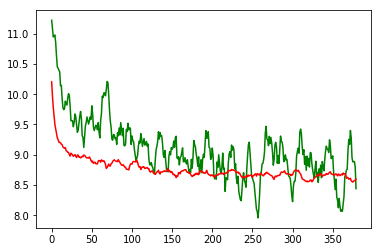

In [130]:
# plt.plot(loss_values)
window_size = 10
plt.plot(smooth([l[0] for l in loss_values], window_size)[window_size:-window_size], 'g')
plt.plot(smooth([l[1] for l in loss_values], window_size)[window_size:-window_size], 'r')

In [236]:
device = torch.device("cuda:0")
index = 1208
f = preprocessFeatures(feats)[index:index+1].to(device)
o = preprocessObservations(obs)[index:index+1]
print(model(f))
print(o)

tensor([[0.]], device='cuda:0', grad_fn=<FeatureDropoutBackward>)
tensor([[3.3673]])


In [172]:
summary(model, (2, 40, 40))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [11]:

# feats, obs = dataGatherOnlyObservedSolutions()
# torch.save(feats, 'train_nokey_only_solution_feats.pt')
# torch.save(obs, 'train_nokey_only_solution_obs.pt')

In [158]:
feats = torch.load('train_nokey_only_solution_feats.pt')
obs = torch.load('train_nokey_only_solution_obs.pt')
print(feats.shape)
print(obs.shape)

torch.Size([3960, 2, 40, 40])
torch.Size([3960, 1])


In [77]:
permTempFeats

tensor([[[[0.2014, 0.8822, 0.1140, 0.8369],
          [0.2918, 0.7020, 0.7541, 0.3556],
          [0.5786, 0.8386, 0.7378, 0.5152],
          [0.9454, 0.2910, 0.9145, 0.5884]],

         [[0.7923, 0.7909, 0.1098, 0.3195],
          [0.4803, 0.4007, 0.6035, 0.5743],
          [0.0171, 0.2761, 0.9388, 0.6652],
          [0.5459, 0.6032, 0.4494, 0.3658]]],


        [[[0.7770, 0.7051, 0.3316, 0.8457],
          [0.2978, 0.7117, 0.1090, 0.3297],
          [0.6302, 0.1306, 0.3089, 0.6453],
          [0.1877, 0.4400, 0.6960, 0.0021]],

         [[0.6115, 0.4842, 0.6426, 0.3837],
          [0.9901, 0.3421, 0.5447, 0.2467],
          [0.8325, 0.7696, 0.2741, 0.2561],
          [0.2276, 0.2711, 0.4679, 0.4610]]],


        [[[0.3534, 0.6828, 0.2816, 0.1926],
          [0.4594, 0.9886, 0.3416, 0.1624],
          [0.8285, 0.4373, 0.4972, 0.4604],
          [0.5750, 0.9687, 0.7848, 0.4529]],

         [[0.0018, 0.5595, 0.9077, 0.3239],
          [0.2525, 0.5788, 0.6479, 0.9415],
          [0.1342,

In [78]:
temp1 = preprocessFeatures(permTempFeats)
print(temp1)

torch.Size([2, 4, 4, 3])
torch.Size([2, 48])
tensor([0.5242, 0.5069])
tensor([0.2678, 0.2553])
tensor([[[[-1.2056,  1.3370, -1.5320,  1.1678],
          [-0.8682,  0.6639,  0.8585, -0.6299],
          [ 0.2030,  1.1740,  0.7977, -0.0338],
          [ 1.5730, -0.8710,  1.4576,  0.2395]],

         [[ 1.1182,  1.1127, -1.5556, -0.7341],
          [-0.1041, -0.4160,  0.3785,  0.2643],
          [-1.9189, -0.9039,  1.6920,  0.6203],
          [ 0.1530,  0.3772, -0.2251, -0.5525]]],


        [[[ 0.9440,  0.6756, -0.7194,  1.2005],
          [-0.8456,  0.7002, -1.5508, -0.7266],
          [ 0.3958, -1.4700, -0.8040,  0.4520],
          [-1.2569, -0.3144,  0.6414, -1.9500]],

         [[ 0.4101, -0.0887,  0.5317, -0.4824],
          [ 1.8931, -0.6453,  0.1483, -1.0191],
          [ 1.2756,  1.0292, -0.9119, -0.9826],
          [-1.0943, -0.9238, -0.1526, -0.1799]]],


        [[[-0.6380,  0.5920, -0.9061, -1.2384],
          [-0.2422,  1.7343, -0.6820, -1.3513],
          [ 1.1363, -0.3245, 

In [52]:
temp1 = [0.2014, 0.8822, 0.1140, 0.8369, 0.2918, 0.7020, 0.7541, 0.3556, 0.5786, 0.8386, 0.7378, 0.5152, 0.9454, 0.2910, 0.9145, 0.5884, \
0.7770, 0.7051, 0.3316, 0.8457, 0.2978, 0.7117, 0.1090, 0.3297, 0.6302, 0.1306, 0.3089, 0.6453, 0.1877, 0.4400, 0.6960, 0.0021, \
0.3534, 0.6828, 0.2816, 0.1926, 0.4594, 0.9886, 0.3416, 0.1624, 0.8285, 0.4373, 0.4972, 0.4604, 0.5750, 0.9687, 0.7848, 0.4529]
sum(temp1) / len(temp1)

0.52423125

In [64]:
transform = transforms.Normalize()

TypeError: __init__() missing 2 required positional arguments: 'mean' and 'std'

In [4]:
DF_COLUMNS = ['Epoch', 'Loss', 'Run Type', 'Model']
def getEmptyDataFrame():
    return pd.DataFrame(columns=DF_COLUMNS)

In [56]:
def graphCompareModelLosses(data, dep_axis_title, graph_title, output_name):
    """
    Args:
        data (list): List of dataframe loss data for each model
        graph_title (str): string name of graph title
        output_name (str): string name of the output png (not including extension)
        
    Outputs:
        Seaborn plot of loss data for training/testing the models
    """
    # Create dataframes for data input and join
    df = getEmptyDataFrame()
    
    # Join dataframes
    for d in data:
        df = df.append(d, ignore_index=True)

    sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, 
                                 'xtick.labelsize': 15, 'ytick.labelsize': 15, 'legend.fontsize': 20}) 
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    ax.set_title(graph_title)
#     ax.set
    g = sns.lineplot(x="Epoch", y="Loss", hue="Model", style="Run Type", data=df)
    g.set(ylabel=dep_axis_title)
    g.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.legend(bbox_to_anchor=(1.0, 1.00))
    fig.savefig(output_name + '.png', facecolor=fig.get_facecolor())

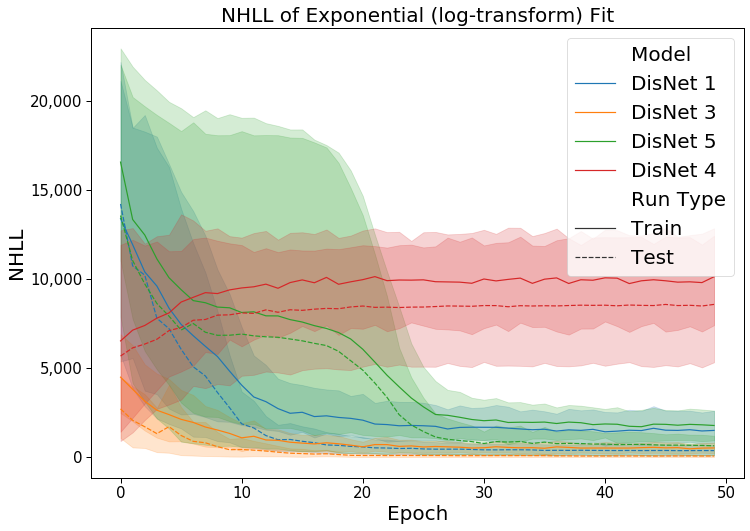

In [129]:
# df_mode2_invgaus_const (0), 8, 6
#data = [data[0], data[1], data[11], data[8], data[6]]
#df_mode2_lognorm_const (stationary=1), good=(2, 6, 8)
#data = [data[2], data[3], data[4], data[7], data[8]] (2)

# df_mode3_expo_const_
#data = [data[2], data[0], data[4]]
maxVal = 5000
data= []
for i in range(0, 8):
    data.append(pd.read_pickle("./data_out/df_mode3_expo_const_{}.pkl".format(i+1)))
# data = [data[3], data[6]]
# data = [data[0], data[1], data[5]]
data = [data[0], data[2], data[4], data[3]]
# del data[6]
# del data[-1]
graphCompareModelLosses(data, dep_axis_title="NHLL", 
                        graph_title="NHLL of Exponential (log-transform) Fit", output_name="expo3_compare_1")

In [ ]:
maxVal = 5000
data= []
for i in range(0, 12):
    data.append(pd.read_pickle("./data_out/df_mode2_invgaus_const_{}.pkl".format(i+1)))
data = [data[0], data[1], data[11], data[8], data[6]]
graphCompareModelLosses(data, "NLHH", "NLLH", "test1")

In [2]:
data_path = "../../training_data/"
data_levelsets = ["train1", "train2", "train3", "train4"]
data_levels = range(1, 990+1)
observation_ext = "observation.zip"
feature_ext = "feature.zip"
feature_closed_ext = "feature_closed.zip"

def _addRowAndCol(feature_tensor):
    # 3xnxn -> 3x(n+1)x(n+1)
    n = feature_tensor.size()[1]
    channels = []
    new_col = torch.zeros(n, 1)
    new_row = torch.zeros(1, n+1)
    for channel in feature_tensor:
        output_tensor = torch.cat((channel, new_col), dim=1)
        output_tensor = torch.cat((output_tensor, new_row), dim=0)
        channels.append(output_tensor)
    return torch.stack(channels)
    
def _reformatLevel(path):
    level_features = torch.load(path)
    fixed_features = []
    for feat in level_features:
        fixed_features.append(_addRowAndCol(feat.clone()))
    del level_features
    torch.save(torch.stack(fixed_features), path)
    
def reformatLevelsetData():
    for levelset, levelnum in itertools.product(*[data_levelsets, data_levels]):
        level_feature_path = '{}{}_{}_{}'.format(data_path, levelset, levelnum, feature_ext)
        level_feature_closed_path = '{}{}_{}_{}'.format(data_path, levelset, levelnum, feature_closed_ext)
        
        # Normal features
        _reformatLevel(level_feature_path)
        _reformatLevel(level_feature_closed_path)

In [3]:
# reformatLevelsetData()

In [3]:
# Byte offsets for level information
LVL_SIZE_OFFSET_HIGH    = int("0x96", 16)
LVL_SIZE_OFFSET_LOW     = int("0x97", 16)
ROW_OFFSET              = int("0x87", 16)
COL_OFFSET              = int("0x84", 16)
BODY_OFFSET             = int("0x98", 16)


def _setByte(file, offset, byte):
    # Set the byte at the given offset to the byte data given.
    # File pointer is then reset back to the end
    file.seek(offset, 0)
    file.write(byte)
    file.seek(0, 2)

def _setLevelSize(file, level_width, level_height):
    # Set the level size information
    # Data to be set is the level width/height and number of bytes containing level information
    assert level_width < 128
    assert level_height < 128

    level_size = 2 * level_width * level_height
    level_size_high = (level_size & 0xFF00) >> 8
    level_size_low = level_size & 0x00FF

    # Size needed to represent all tiles in the level
    _setByte(file, LVL_SIZE_OFFSET_HIGH,  bytes([level_size_high]))
    _setByte(file, LVL_SIZE_OFFSET_LOW,  bytes([level_size_low]))

    # Level size in height/width
    _setByte(file, ROW_OFFSET,  bytes([level_height]))
    _setByte(file, COL_OFFSET,  bytes([level_width]))
    
    
def _writeSpriteByte(file, sprite):
    sprite_high = (sprite & 0xFF00) >> 8
    sprite_low = sprite & 0x00FF
    file.write(bytes([sprite_high]))
    file.write(bytes([sprite_low]))
        
    
def makeFileFromLevel(filename_in, filename_out):
    # Write header
    file_in = open(filename_in, 'rb')
    file_out = open(filename_out, 'wb')
    wall_steel = 0x000D
    
    start_pos = 152
    end_pos = 3194
    index = 0
    counter = 0
    
    byte = file_in.read(1)
    while byte:
        # Do stuff with byte.
        file_out.write(byte)
        
        if index > start_pos and index <= end_pos and (index - start_pos + 1) % (39*2) == 0:
            _writeSpriteByte(file_out, wall_steel)
            counter += 1
        
        # Reset byte
        byte = file_in.read(1)
        index += 1
          
        # Last row
        if counter == 39:
            for _ in range(40):
                _writeSpriteByte(file_out, wall_steel)
            counter += 1
    
    # Set new level size
    _setLevelSize(file_out, 40, 40)
    
    file_in.close()
    file_out.close()

In [5]:
level_dir = "../../../../levels/"
data_levelsets = ["train5", "train6", "train7", "train8"]
data_levels = range(1, 990+1)
for levelset, levelnum in itertools.product(*[data_levelsets, data_levels]):
    level_in = '{}{}/{:0>3d}.level'.format(level_dir, levelset, levelnum)
    level_out = '{}{}/{:0>3d}.level'.format(level_dir, levelset, levelnum)
    makeFileFromLevel(level_in, level_out)

In [13]:
temp = torch.zeros([10, 2])
temp1 = torch.randn(temp.shape)

In [17]:
temp1 = torch.stack([torch.randn(temp.shape)]) + 10
temp1 = temp1[0]
print(temp1)
print(temp1.shape)

tensor([[ 9.5344, 10.0694],
        [10.0049, 10.4041],
        [ 8.2787, 10.5917],
        [ 9.8316, 10.0829],
        [ 9.2838, 10.9231],
        [10.5118,  9.5780],
        [ 9.7765, 10.1739],
        [ 9.8295,  9.5003],
        [ 9.5293, 10.7727],
        [ 9.6125,  8.3465]])
torch.Size([10, 2])


In [18]:
temp1[:,0:1] = torch.log(temp1[:,0:1])
temp1

tensor([[ 2.2549, 10.0694],
        [ 2.3031, 10.4041],
        [ 2.1137, 10.5917],
        [ 2.2856, 10.0829],
        [ 2.2283, 10.9231],
        [ 2.3525,  9.5780],
        [ 2.2800, 10.1739],
        [ 2.2854,  9.5003],
        [ 2.2544, 10.7727],
        [ 2.2631,  8.3465]])

In [20]:
temp1[:,0:1].sum()

tensor(22.6209)

In [64]:
temp1.repeat(2, 1, 1, 1)

tensor([[[[ 2.4730, -1.5877, -0.1906],
          [ 1.3830, -0.0441,  1.6279],
          [ 0.1986, -0.3781,  0.1552]],

         [[ 0.1887,  1.4749,  2.2969],
          [-2.0679, -0.5173,  0.1731],
          [ 0.1199,  0.1924, -0.4836]]],


        [[[ 2.4730, -1.5877, -0.1906],
          [ 1.3830, -0.0441,  1.6279],
          [ 0.1986, -0.3781,  0.1552]],

         [[ 0.1887,  1.4749,  2.2969],
          [-2.0679, -0.5173,  0.1731],
          [ 0.1199,  0.1924, -0.4836]]]])

In [6]:
temp = torch.load('../dataset_attributes/lb_16_std.pt')
temp

tensor([0.1287, 0.1206])

In [89]:
temp1

tensor([[ 2.2549, 10.0694],
        [ 2.3031, 10.4041],
        [ 2.1137, 10.5917],
        [ 2.2856, 10.0829],
        [ 2.2283, 10.9231],
        [ 2.3525,  9.5780],
        [ 2.2800, 10.1739],
        [ 2.2854,  9.5003],
        [ 2.2544, 10.7727],
        [ 2.2631,  8.3465]])

In [41]:
mus = temp1.mean(dim=1, keepdim=True)
print(mus)
temp11 = (1.0 / temp1) - (1.0/mus)
print(temp11)
temp22 = temp11.sum(dim=1, keepdim=True)
temp22 = temp22 / 2.0
print((1.0 /temp22).flatten())
print(temp1.mean(dim=1))

tensor([[6.1621],
        [6.3536],
        [6.3527],
        [6.1843],
        [6.5757],
        [5.9653],
        [6.2270],
        [5.8929],
        [6.5135],
        [5.3048]])
tensor([[ 0.2812, -0.0630],
        [ 0.2768, -0.0613],
        [ 0.3157, -0.0630],
        [ 0.2758, -0.0625],
        [ 0.2967, -0.0605],
        [ 0.2574, -0.0632],
        [ 0.2780, -0.0623],
        [ 0.2679, -0.0644],
        [ 0.2901, -0.0607],
        [ 0.2534, -0.0687]])
tensor([ 9.1648,  9.2792,  7.9147,  9.3766,  8.4682, 10.2980,  9.2719,  9.8315,
         8.7200, 10.8301])
tensor([6.1621, 6.3536, 6.3527, 6.1843, 6.5757, 5.9653, 6.2270, 5.8929, 6.5135,
        5.3048])


In [52]:
a = torch.randn([10])
print(a)
a = a.repeat(2, 1)
print(a)
print(a[:,0])

tensor([-6.6876e-01, -1.4173e-04,  6.2986e-01, -1.6624e+00,  2.3641e-01,
        -1.2193e-01,  2.1424e+00,  8.2257e-01, -4.7983e-01, -3.0165e-01])
tensor([[-6.6876e-01, -1.4173e-04,  6.2986e-01, -1.6624e+00,  2.3641e-01,
         -1.2193e-01,  2.1424e+00,  8.2257e-01, -4.7983e-01, -3.0165e-01],
        [-6.6876e-01, -1.4173e-04,  6.2986e-01, -1.6624e+00,  2.3641e-01,
         -1.2193e-01,  2.1424e+00,  8.2257e-01, -4.7983e-01, -3.0165e-01]])
tensor([-0.6688, -0.6688])


In [72]:
a = torch.tensor([[1], [4], [7], [10]])
print(a)

tensor([[ 1],
        [ 4],
        [ 7],
        [10]])


In [79]:
b = a.repeat(3,1)
print(b)

tensor([[ 1],
        [ 4],
        [ 7],
        [10],
        [ 1],
        [ 4],
        [ 7],
        [10],
        [ 1],
        [ 4],
        [ 7],
        [10]])


In [88]:
outputs = torch.zeros(a.shape[0], 3)
print(outputs)
for i in range(4):
    outputs[i] = b[i::4].flatten()
#     print(b[i::4].flatten())
print(outputs)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[ 1.,  1.,  1.],
        [ 4.,  4.,  4.],
        [ 7.,  7.,  7.],
        [10., 10., 10.]])


In [83]:
b[0::4]
#torch.gather(b, dim=0, torch.tensor([1]))

tensor([[1],
        [1],
        [1]])